In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing import image

import os
import numpy as np

2025-02-19 10:53:20.096174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use only the first GPU (GPU:0)
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

class UNet(tf.keras.Model):
    def __init__(self, input_size=(256, 256, 3), num_classes=1):
        super().__init__()

        self.input_size = input_size
        self.num_classes = num_classes

        # Contracting Path (Encoder)
        self.conv1 = self.conv_block(64)
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        self.conv2 = self.conv_block(128)
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        self.conv3 = self.conv_block(256)
        self.pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        self.conv4 = self.conv_block(512)
        self.pool4 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        # Bottleneck
        self.bottleneck = self.conv_block(1024)

        # Expansive Path (Decoder)
        self.upsample4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')
        self.upconv4 = self.conv_block(512)

        self.upsample3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')
        self.upconv3 = self.conv_block(256)

        self.upsample2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')
        self.upconv2 = self.conv_block(128)

        self.upsample1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')
        self.upconv1 = self.conv_block(64)

        # Output layer with a 1x1 convolution (sigmoid for binary classification)
        self.output_layer = layers.Conv2D(self.num_classes, (1, 1), activation='sigmoid', padding='same')

    def conv_block(self, filters, kernel_size=(3, 3), padding='same', strides=(1, 1)):
        return models.Sequential([
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

    def call(self, inputs):

        # Contracting path (encoder)
        enc1 = self.conv1(inputs)  # 256x256x3 -> 256x256x64
        pool1 = self.pool1(enc1)   # 256x256x64 -> 128x128x64

        enc2 = self.conv2(pool1)   # 128x128x64 -> 128x128x128
        pool2 = self.pool2(enc2)   # 128x128x128 -> 64x64x128

        enc3 = self.conv3(pool2)   # 64x64x128 -> 64x64x256
        pool3 = self.pool3(enc3)   # 64x64x256 -> 32x32x256

        enc4 = self.conv4(pool3)   # 32x32x256 -> 32x32x512
        pool4 = self.pool4(enc4)   # 32x32x512 -> 16x16x512

        # Bottleneck
        bottleneck = self.bottleneck(pool4)  # 16x16x512 -> 16x16x1024

        # Expansive path (decoder)
        up4 = self.upsample4(bottleneck)   # 16x16x1024 -> 32x32x512
        up4 = layers.Concatenate(axis=-1)([up4, enc4])  # 32x32x512 + 32x32x512 -> 32x32x1024
        up4 = self.upconv4(up4) # 32x32x1024 -> 32x32x512

        up3 = self.upsample3(up4) # 32x32x512 -> 64x64x256
        up3 = layers.Concatenate(axis=-1)([up3, enc3]) # 64x64x256 + 64x64x256 -> 64x64x512
        up3 = self.upconv3(up3) # 64x64x512 -> 64x64x256

        up2 = self.upsample2(up3) # 64x64x256 -> 128x128x128
        up2 = layers.Concatenate(axis=-1)([up2, enc2]) # 128x128x128 + 128x128x128 -> 128x128x256
        up2 = self.upconv2(up2) # 128x128x256 -> 128x128x128

        up1 = self.upsample1(up2) # 128x128x128 -> 256x256x64
        up1 = layers.Concatenate(axis=-1)([up1, enc1]) # 256x256x64 + 256x256x64 -> 256x256x128
        up1 = self.upconv1(up1) # 256x256x128 -> 256x256x64

        # Output layer
        output = self.output_layer(up1)  # 256x256x64 -> 256x256x1

        return output

    # Methods needed for correct serialization and loading of the trained model
    def get_config(self):
        """ Returns the config dictionary for serialization """
        config = super().get_config()
        config.update({
            "input_size": self.input_size,
            "num_classes": self.num_classes
        })
        return config

    @classmethod
    def from_config(cls, config):
        """ Creates an instance from the config dictionary """
        return cls(**config)


In [4]:
# Instantiate the model

unet = UNet(input_size=(256, 256, 1), num_classes=1)

# Summary of the model architecture
unet.build((None, 256, 256, 1))  # Input shape
unet.summary()

/Users/damianobaschiera/Python/CV Skin Lesions/CV-skin-lesions/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'u_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "u_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:

def load_image(image_path):
    """Load an image, decode it, and resize to 256x256"""
    img = tf.io.read_file(image_path)               # Read image
    img = tf.image.decode_png(img, channels=3)       # Decode as PNG (assuming PNG images)
    img = tf.image.resize(img, (256, 256))           # Resize to target size
    img = img / 255.0                               # Normalize to range [0, 1]
    return img

def load_mask(mask_path):
    """Load a mask, decode it, and resize to 256x256"""
    mask = tf.io.read_file(mask_path)               # Read mask image
    mask = tf.image.decode_png(mask, channels=1)     # Decode as PNG (assuming masks are single-channel)
    mask = tf.image.resize(mask, (256, 256))         # Resize to target size
    mask = mask / 255.0                             # Normalize to range [0, 1]
    return mask

def load_data(image_folder, mask_folder):
    # Get image and mask file paths
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]
    mask_paths = [os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder)]

    # Shuffle the paths (optional)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Load images and masks
    dataset = dataset.map(lambda x, y: (load_image(x), load_mask(y)))

    # Shuffle and batch the dataset
    # dataset = dataset.shuffle(buffer_size=1000)  # Shuffle with buffer_size (adjust as needed)
    dataset = dataset.batch(batch_size=16)  # Batch size for training (adjust as needed)

    return dataset


In [18]:
# Set the directory paths
image_folder = 'normalized_images'
mask_folder = 'normalized_masks'

# Load the dataset
train_dataset = load_data(image_folder, mask_folder)

# Check the dataset shapes (optional)
for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 1)


2025-02-19 11:12:37.782282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cross entropy Loss

In [ ]:
# Compile the model
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
unet.fit(train_dataset, epochs=5)  # Adjust the number of epochs as needed

DICE Loss

In [7]:
import tensorflow as tf
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1e-7
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice  # Hybrid loss (equal weighting)

@tf.function
def dice_score(y_true, y_pred):
    smooth = 1e-7
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

@tf.function
def iou_score(y_true, y_pred):
    smooth = 1e-7
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)



In [11]:
unet.compile(optimizer='adam', loss=bce_dice_loss, metrics=[iou_score, dice_score])
unet.fit(train_dataset, epochs=20)  # Adjust the number of epochs as needed

Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 321s 652ms/step - dice_score: 0.4709 - iou_score: 0.3118 - loss: 0.5217
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


356/394 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - dice_score: 0.6742 - iou_score: 0.5107 - loss: 0.3463

KeyboardInterrupt: 

## Save the model

In [ ]:
# Save model architecture + weights properly
unet.save("/content/drive/MyDrive/CV project/unet_model.keras")

In [ ]:
# Rebuild model manually
unet_new = UNet(input_size=(256, 256, 3), num_classes=1)

# Pass a dummy input to initialize layers
dummy_input = tf.random.normal([1, 256, 256, 3])  # Batch size 1, image size 256x256, 3 channels
_ = unet_new(dummy_input)  # Call the model once to initialize it

# Load saved weights
unet_new.load_weights("/content/drive/MyDrive/CV project/unet_model.keras")

# Recompile the model (since optimizer was lost)
unet_new.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Verify that the model architecture is now correctly built
unet_new.summary()


Model: "u_net_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_126 (Sequential)          │ (1, 256, 256, 64)           │          39,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_56 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_127 (Sequential)          │ (1, 128, 128, 128)          │         222,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_57 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_128 (Sequential)          │ (1, 64, 64, 256)            │         887,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_58 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_129 (Sequential)          │ (1, 32, 32, 512)            │       3,544,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_59 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_130 (Sequential)          │ (1, 16, 16, 1024)           │      14,166,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_131 (Sequential)          │ (1, 32, 32, 512)            │       4,461,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_132 (Sequential)          │ (1, 64, 64, 256)            │       1,640,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_133 (Sequential)          │ (1, 128, 128, 128)          │         410,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_134 (Sequential)          │ (1, 256, 256, 64)           │         103,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_224 (Conv2D)                  │ (1, 256, 256, 1)            │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,475,649 (97.18 MB)

 Trainable params: 25,463,873 (97.14 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
# Define test dataset directories
test_images_dir = "/content/drive/MyDrive/CV project/test_normalized_images"
test_masks_dir = "/content/drive/MyDrive/CV project/test_normalized_masks"

# Load test dataset using existing `load_data()` function
test_dataset = load_data(test_images_dir, test_masks_dir)


In [ ]:
loss, accuracy = unet_new.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.7654 - loss: 0.5365
Test Loss: 0.5312897562980652, Test Accuracy: 0.7678108215332031


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get sorted image filenames (only images, not masks)
image_filenames = sorted([f for f in os.listdir(test_images_dir) if f.endswith(".jpg")])

# Iterate Over Images and Select Corresponding Mask
image_list = []
y_true_list = []
y_pred_list = []

for img_filename in image_filenames:
    img_path = os.path.join(test_images_dir, img_filename)

    # Construct the corresponding mask filename
    mask_filename = img_filename.replace(".jpg", "_Segmentation.png")
    mask_path = os.path.join(test_masks_dir, mask_filename)

    # Load image and mask using your existing functions
    image_np = load_image(img_path).numpy()
    mask_tensor = load_mask(mask_path)  # Full mask path is passed correctly

    if mask_tensor is None:
        print(f" Skipping: No mask found for {img_filename}")
        continue  # Skip this image if the mask is missing

    mask_np = mask_tensor.numpy()

    # Get model prediction
    predicted_mask = unet.predict(np.expand_dims(image_np, axis=0))  # Add batch dimension

    # Threshold prediction to binary mask
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Store correctly paired results
    image_list.append(image_np)
    y_true_list.append(mask_np)
    y_pred_list.append(predicted_mask.squeeze())  # Remove batch dimension

# Convert Lists to Arrays
image_data = np.array(image_list)  # Shape: (N, 256, 256, 3)
y_true = np.array(y_true_list)  # Shape: (N, 256, 256, 1)
y_pred = np.array(y_pred_list)  # Shape: (N, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━

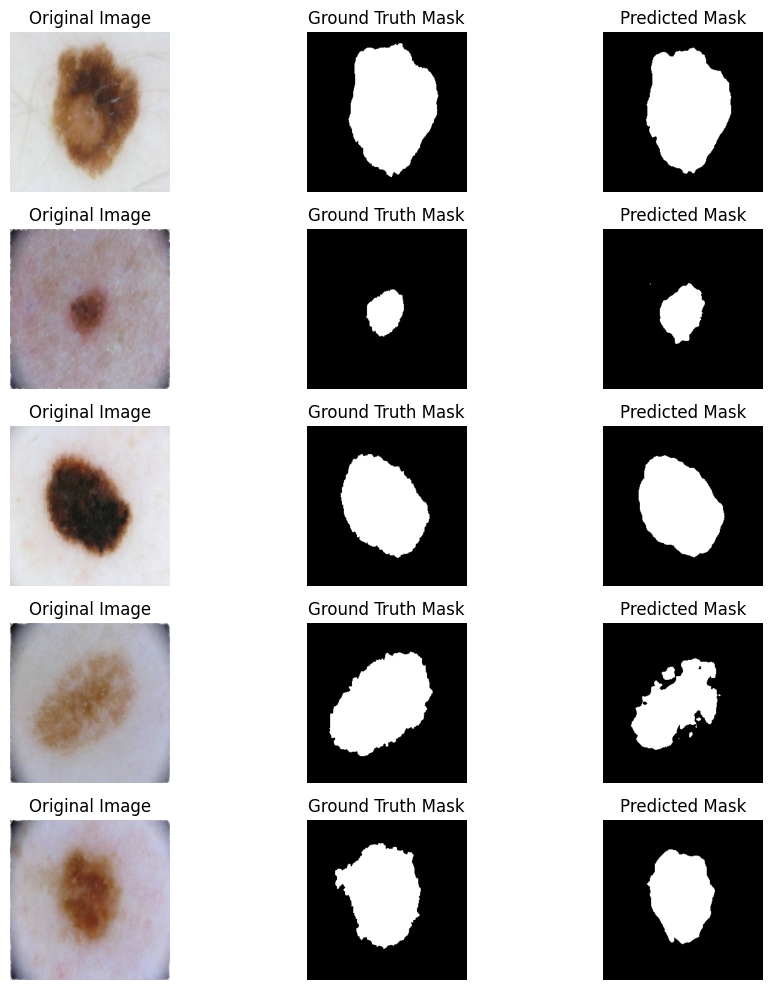

In [ ]:
# Visualize First 5 Image-Mask-Prediction Pairs
num_images_to_show = 5
fig, axes = plt.subplots(num_images_to_show, 3, figsize=(10, 10))

for i in range(num_images_to_show):
    axes[i, 0].imshow(image_data[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(np.squeeze(y_true[i]), cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Compute Metrics
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Compute Jaccard IoU Score
iou_score = jaccard_score(y_true_flat, y_pred_flat)

# Compute Dice Score
dice_score = (2.0 * np.sum(y_true_flat * y_pred_flat)) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-7)

# Compute Binary Cross-Entropy (BCE) Loss
bce_loss = -np.mean(y_true_flat * np.log(y_pred_flat + 1e-7) + (1 - y_true_flat) * np.log(1 - y_pred_flat + 1e-7))

# Print Metrics
print(f"Test Jaccard IoU: {iou_score:.4f}")
print(f"Test Dice Score: {dice_score:.4f}")
print(f"Test Binary Cross-Entropy Loss: {bce_loss:.4f}")

Test Jaccard IoU: 0.5995
Test Dice Score: 0.7496
Test Binary Cross-Entropy Loss: 1.9093


# Data Augmentation

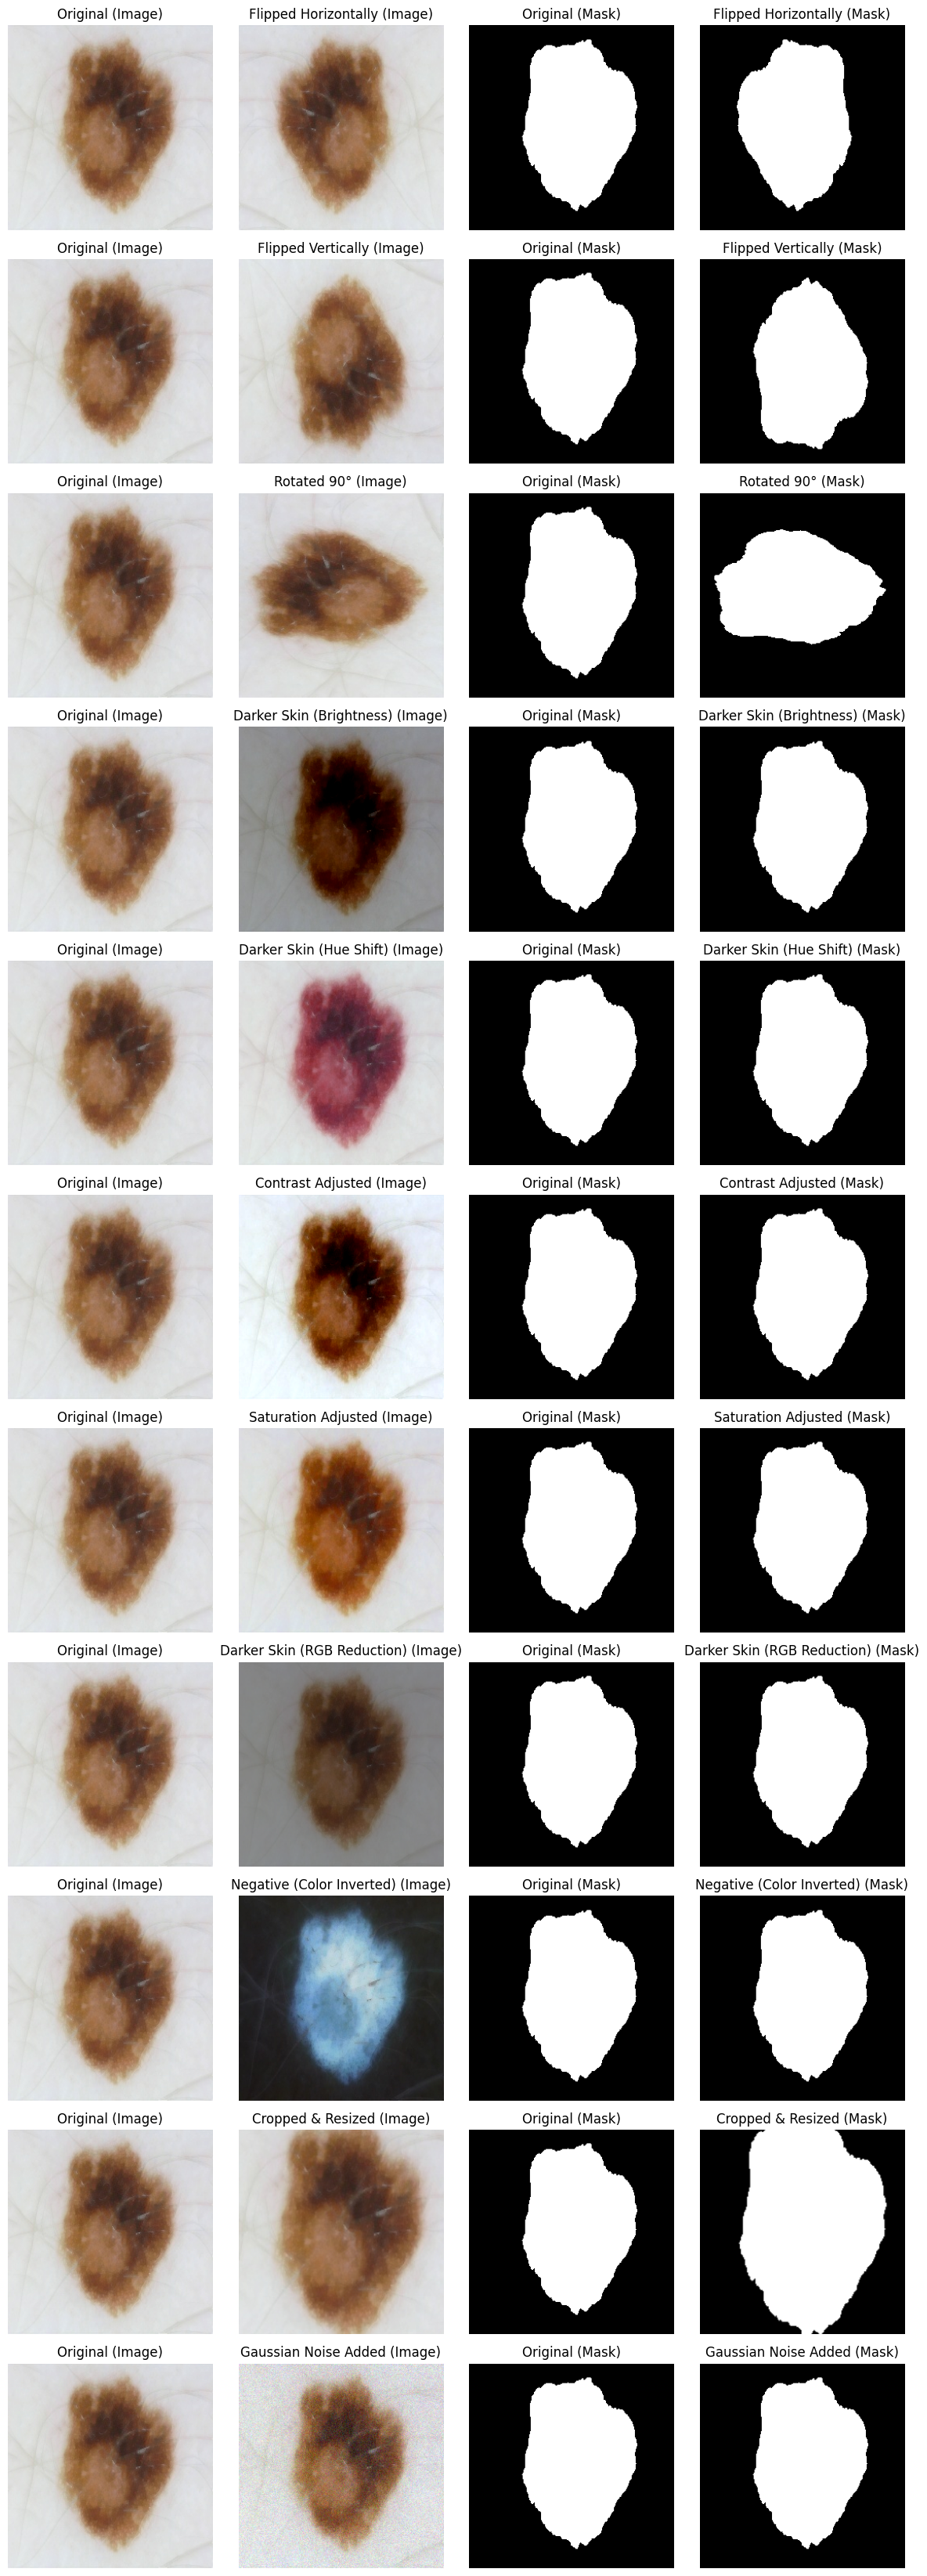

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the first image and mask from the dataset
image_filenames = sorted([f for f in os.listdir(test_images_dir) if f.endswith(".jpg")])
first_img_path = os.path.join(test_images_dir, image_filenames[0])

# Construct corresponding mask filename
mask_filename = image_filenames[0].replace(".jpg", "_Segmentation.png")
first_mask_path = os.path.join(test_masks_dir, mask_filename)

# Load the original image and mask
original_image = load_image(first_img_path)
original_mask = load_mask(first_mask_path)

# Ensure they are tensors
original_image = tf.convert_to_tensor(original_image)
original_mask = tf.convert_to_tensor(original_mask)

# Define augmentation functions
def apply_augmentations(image, mask):
    augmented_images = []
    augmented_masks = []
    titles = []

    def add_augmentation(aug_img, aug_mask, title):
        # Convert tensors to NumPy if necessary
        aug_img_np = aug_img.numpy() if isinstance(aug_img, tf.Tensor) else aug_img
        aug_mask_np = aug_mask.numpy() if isinstance(aug_mask, tf.Tensor) else aug_mask
        orig_img_np = image.numpy() if isinstance(image, tf.Tensor) else image
        orig_mask_np = mask.numpy() if isinstance(mask, tf.Tensor) else mask

        augmented_images.append((orig_img_np, aug_img_np))  # Original vs Augmented
        augmented_masks.append((orig_mask_np, aug_mask_np))   # Original vs Augmented Mask
        titles.append(title)

    # Flip Horizontally
    img_flip_h, mask_flip_h = tf.image.flip_left_right(image), tf.image.flip_left_right(mask)
    add_augmentation(img_flip_h, mask_flip_h, "Flipped Horizontally")

    # Flip Vertically
    img_flip_v, mask_flip_v = tf.image.flip_up_down(image), tf.image.flip_up_down(mask)
    add_augmentation(img_flip_v, mask_flip_v, "Flipped Vertically")

    # Rotate 90 degrees
    img_rot90, mask_rot90 = tf.image.rot90(image), tf.image.rot90(mask)
    add_augmentation(img_rot90, mask_rot90, "Rotated 90°")

    # Adjust Brightness (Make Skin Darker)
    img_darker = tf.image.adjust_brightness(image, delta=-0.3)  # Reduce brightness
    add_augmentation(img_darker, mask, "Darker Skin (Brightness)")

    # Adjust Hue (Shift Towards Brown)
    img_hue = tf.image.adjust_hue(image, delta=-0.1)  # Shift hue towards brownish colors
    add_augmentation(img_hue, mask, "Darker Skin (Hue Shift)")

    # Adjust Contrast
    img_contrast = tf.image.adjust_contrast(image, contrast_factor=1.5)
    add_augmentation(img_contrast, mask, "Contrast Adjusted")

    # Adjust Saturation
    img_saturation = tf.image.adjust_saturation(image, saturation_factor=1.5)
    add_augmentation(img_saturation, mask, "Saturation Adjusted")

    # Reduce RGB Values (Alternative Skin Darkening)
    img_darker_rgb = image * 0.6  # Reduce RGB values to darken the skin
    add_augmentation(img_darker_rgb, mask, "Darker Skin (RGB Reduction)")

    # **Invert Colors (Negative Transformation)**
    img_inverted = 1.0 - image  # Invert colors
    add_augmentation(img_inverted, mask, "Negative (Color Inverted)")

    # Random Cropping & Resizing
    crop_size = 200
    img_cropped = tf.image.resize_with_crop_or_pad(image, crop_size, crop_size)
    mask_cropped = tf.image.resize_with_crop_or_pad(mask, crop_size, crop_size)
    img_cropped = tf.image.resize(img_cropped, (256, 256))
    mask_cropped = tf.image.resize(mask_cropped, (256, 256))
    add_augmentation(img_cropped, mask_cropped, "Cropped & Resized")

    # Add Gaussian Noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    img_noise = tf.clip_by_value(image + noise, 0.0, 1.0)
    add_augmentation(img_noise, mask, "Gaussian Noise Added")

    return augmented_images, augmented_masks, titles

# Apply augmentations
augmented_images, augmented_masks, titles = apply_augmentations(original_image, original_mask)

# Plot the results: Before (left) vs After (right)
num_augmentations = len(augmented_images)
fig, axes = plt.subplots(num_augmentations, 4, figsize=(12, num_augmentations * 3))

for i in range(num_augmentations):
    before_img, after_img = augmented_images[i]
    before_mask, after_mask = augmented_masks[i]

    # Show Original Image
    axes[i, 0].imshow(before_img)
    axes[i, 0].set_title(f"Original (Image)")
    axes[i, 0].axis("off")

    # Show Augmented Image
    axes[i, 1].imshow(after_img)
    axes[i, 1].set_title(f"{titles[i]} (Image)")
    axes[i, 1].axis("off")

    # Show Original Mask
    axes[i, 2].imshow(np.squeeze(before_mask), cmap="gray")
    axes[i, 2].set_title(f"Original (Mask)")
    axes[i, 2].axis("off")

    # Show Augmented Mask
    axes[i, 3].imshow(np.squeeze(after_mask), cmap="gray")
    axes[i, 3].set_title(f"{titles[i]} (Mask)")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()


In [36]:
import os
import random
import numpy as np
import tensorflow as tf
from PIL import Image  # To save images & masks

# Define dataset directories
train_images_dir = "normalized_images"
train_masks_dir = "normalized_masks"

# Define output directories
sampled_images_dir = "sampled_augmented_images"
sampled_masks_dir = "sampled_augmented_masks"

# Ensure output directories exist
os.makedirs(sampled_images_dir, exist_ok=True)
os.makedirs(sampled_masks_dir, exist_ok=True)

def get_filenames(image_folder, mask_folder):
    """Retrieve filenames from both image and mask folders ensuring alignment"""
    image_filenames = sorted([f for f in os.listdir(image_folder) if f.endswith(".png") or f.endswith(".jpg")])
    mask_filenames = [f.replace(".jpg", ".png").replace(".png", "_Segmentation.png") for f in image_filenames]
    return image_filenames, mask_filenames

def augment_image(image):
    """Apply multiple augmentations to an image and return a list of augmented images."""
    augmented_images = []

    def clip(img):
        return tf.clip_by_value(img, 0.0, 1.0)  # Ensure values stay in [0,1]

    # Original
    augmented_images.append(clip(image))

    # Inverted (Negative)
    img_inverted = 1.0 - image
    augmented_images.append(clip(img_inverted))

    # Hue Shift (toward brown)
    img_hue = tf.image.adjust_hue(image, delta=-0.1)
    augmented_images.append(clip(img_hue))

    # Contrast Adjustment
    img_contrast = tf.image.adjust_contrast(image, contrast_factor=1.5)
    augmented_images.append(clip(img_contrast))

    # Saturation Adjustment
    img_saturation = tf.image.adjust_saturation(image, saturation_factor=1.5)
    augmented_images.append(clip(img_saturation))

    # Brightness Adjustment
    img_brightness = tf.image.adjust_brightness(image, delta=0.2)
    augmented_images.append(clip(img_brightness))

    # Gaussian Noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    img_noise = image + noise
    augmented_images.append(clip(img_noise))

    return augmented_images

def process_and_save_data(image_folder, mask_folder, num_samples=300):
    """Select `num_samples` random images, apply augmentation, and save correctly paired results."""
    
    # Get sorted filenames
    image_filenames, mask_filenames = get_filenames(image_folder, mask_folder)

    # Select 300 random images
    selected_indices = random.sample(range(len(image_filenames)), num_samples)
    selected_pairs = [(image_filenames[i], mask_filenames[i]) for i in selected_indices]

    for idx, (img_filename, mask_filename) in enumerate(selected_pairs, start=1):
        # Load original image & mask
        img_path = os.path.join(image_folder, img_filename)
        mask_path = os.path.join(mask_folder, mask_filename)

        image = np.array(Image.open(img_path).convert("RGB")) / 255.0  # Normalize to [0,1]
        mask = np.array(Image.open(mask_path).convert("L")) / 255.0  # Normalize to [0,1]

        # Convert to TensorFlow tensors
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)

        # Apply augmentations
        augmented_images = augment_image(image_tensor)

        for aug_idx, aug_img in enumerate(augmented_images, start=1):
            # Convert back to NumPy and rescale to [0,255]
            aug_img_np = (aug_img.numpy() * 255).astype(np.uint8)
            mask_np = (mask_tensor.numpy() * 255).astype(np.uint8)

            # Define new filenames following `X_1`, `X_2`, etc.
            img_filename_new = f"{idx}_{aug_idx}.png"
            mask_filename_new = f"{idx}_{aug_idx}_mask.png"

            # Save augmented images & masks
            Image.fromarray(aug_img_np).save(os.path.join(sampled_images_dir, img_filename_new))
            Image.fromarray(mask_np).save(os.path.join(sampled_masks_dir, mask_filename_new))

    print(f"✅ {num_samples} images augmented and saved successfully in '{sampled_images_dir}' & '{sampled_masks_dir}'.")

# Run the function
process_and_save_data(train_images_dir, train_masks_dir, num_samples=300)


✅ 300 images augmented and saved successfully in 'sampled_augmented_images' & 'sampled_augmented_masks'.


2025-02-19 11:19:24.296529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


✅ Selected indices: [2391, 5541]


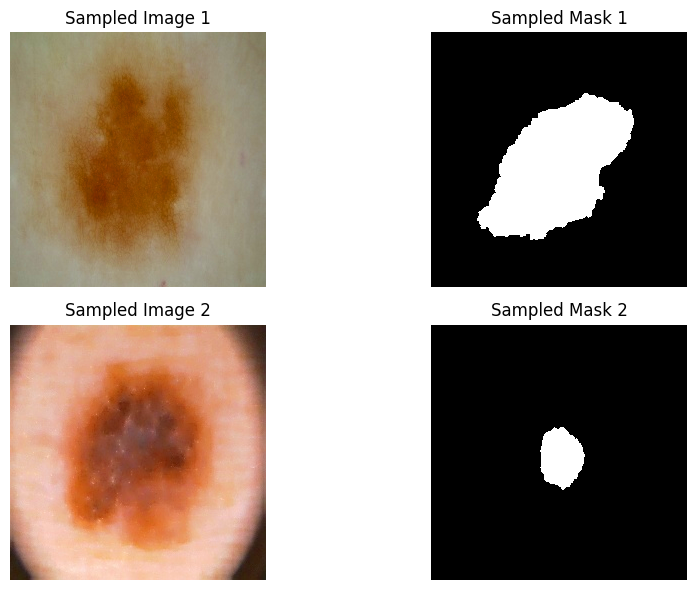

✅ 2 images and masks saved in 'sampled_augmented_images' & 'sampled_augmented_masks'


In [27]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # For saving images

# Define output directories
sampled_images_dir = "sampled_augmented_images"
sampled_masks_dir = "sampled_augmented_masks"

# Ensure output directories exist
os.makedirs(sampled_images_dir, exist_ok=True)
os.makedirs(sampled_masks_dir, exist_ok=True)

def structured_sample_dataset(dataset):
    """Split dataset in half, randomly sample an index, and return a TensorFlow dataset."""
    
    # Unbatch dataset and extract all images and masks
    dataset_unbatched = list(dataset.unbatch().as_numpy_iterator())
    
    # Ensure dataset is properly structured
    images, masks = zip(*dataset_unbatched)
    
    dataset_size = len(images)
    assert dataset_size == len(masks), "Mismatch between images and masks!"

    # Compute half dataset size
    half_size = dataset_size // 2

    # Select a random index `r` in `[0, half_size]`
    r = random.randint(0, half_size - 1)

    # Select two corresponding images/masks: one from the first half, one from the second half
    selected_indices = [r, r + half_size]
    selected_images = [images[i] for i in selected_indices]
    selected_masks = [masks[i] for i in selected_indices]

    # Convert back into a TensorFlow dataset (matching image-mask pairs)
    sampled_dataset = tf.data.Dataset.from_tensor_slices((selected_images, selected_masks))
    
    # Batch the dataset to match visualization method
    sampled_dataset = sampled_dataset.batch(2)  # Keep batch size 2 for visualization

    print(f"✅ Selected indices: {selected_indices}")
    return sampled_dataset

# Sample from dataset (similar to visualization approach)
sampled_train_dataset = structured_sample_dataset(train_dataset)

# ✅ Visualizing Sampled Images & Masks
dataset_iter = iter(sampled_train_dataset)
image_batch, mask_batch = next(dataset_iter)

# Convert tensors to NumPy arrays for visualization
image_batch = image_batch.numpy()
mask_batch = mask_batch.numpy()

# Number of images to display
num_images_to_show = min(2, len(image_batch))  # Display 2 images (since we sampled 2)

fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, num_images_to_show * 3))

for i in range(num_images_to_show):
    # Show the image
    axes[i, 0].imshow(image_batch[i])
    axes[i, 0].set_title(f"Sampled Image {i+1}")
    axes[i, 0].axis("off")

    # Show the corresponding mask
    axes[i, 1].imshow(mask_batch[i].squeeze(), cmap="gray")
    axes[i, 1].set_title(f"Sampled Mask {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# ✅ Saving Sampled Images & Masks
for i in range(num_images_to_show):
    img_filename = f"sampled_{i:04d}.png"
    mask_filename = f"sampled_{i:04d}_mask.png"

    # Convert images & masks to [0,255] format for saving
    img_to_save = (image_batch[i] * 255).astype(np.uint8)
    mask_to_save = (mask_batch[i] * 255).astype(np.uint8)

    Image.fromarray(img_to_save).save(os.path.join(sampled_images_dir, img_filename))
    Image.fromarray(mask_to_save.squeeze()).save(os.path.join(sampled_masks_dir, mask_filename))

print(f"✅ {num_images_to_show} images and masks saved in '{sampled_images_dir}' & '{sampled_masks_dir}'")


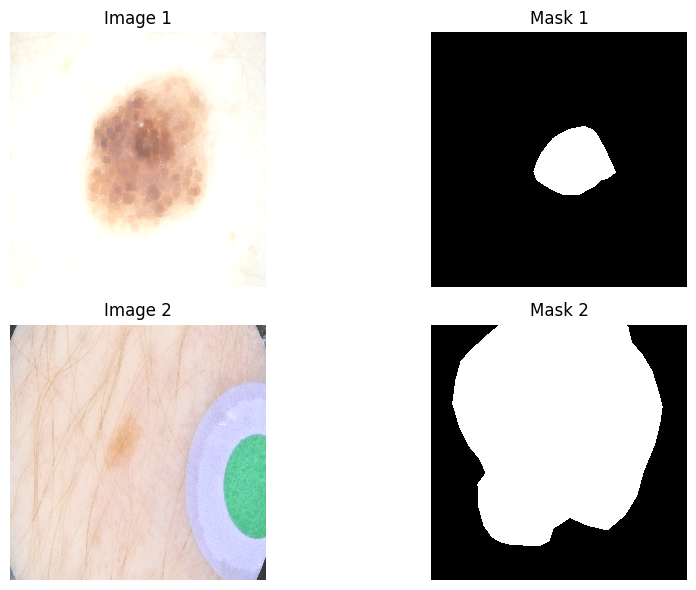

In [25]:
# Get an iterator for the dataset
dataset_iter = iter(sampled_train_dataset)

# Retrieve the first batch
image_batch, mask_batch = next(dataset_iter)

# Convert tensors to NumPy arrays for visualization
image_batch = image_batch.numpy()
mask_batch = mask_batch.numpy()

# Number of images to display
num_images_to_show = min(5, len(image_batch))  # Show up to 5 images

# Plot the images and their corresponding masks
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, num_images_to_show * 3))

for i in range(num_images_to_show):
    # Show the image
    axes[i, 0].imshow(image_batch[i])
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis("off")

    # Show the corresponding mask
    axes[i, 1].imshow(mask_batch[i].squeeze(), cmap="gray")
    axes[i, 1].set_title(f"Mask {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
